In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [26]:
import tensorflow as tf
from  tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D
from  tensorflow.keras.preprocessing import image_dataset_from_directory
from  tensorflow.keras import Sequential


In [27]:
IMAGE_SIZE= 256
SEED_TRAINING=121
SEED_TESTING=197
SEED_VALIDATION=164
CHANNELS=3
EPOCHS=20
BATCH_SIZE=32

In [28]:
train_dataset = image_dataset_from_directory(
    '../Potato_Dataset/Train' , 
    image_size=(IMAGE_SIZE  , IMAGE_SIZE) , 
    batch_size = BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    '../Potato_Dataset/Test' , 
    image_size=(IMAGE_SIZE  , IMAGE_SIZE) , 
    )

val_dataset = image_dataset_from_directory(
    '../Potato_Dataset/Valid' , 
    image_size=(IMAGE_SIZE  , IMAGE_SIZE) , 
)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


Found 300 files belonging to 3 classes.


In [29]:
class_names = train_dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [30]:
print(len(train_dataset))
print( 900 / 32 )

29
28.125


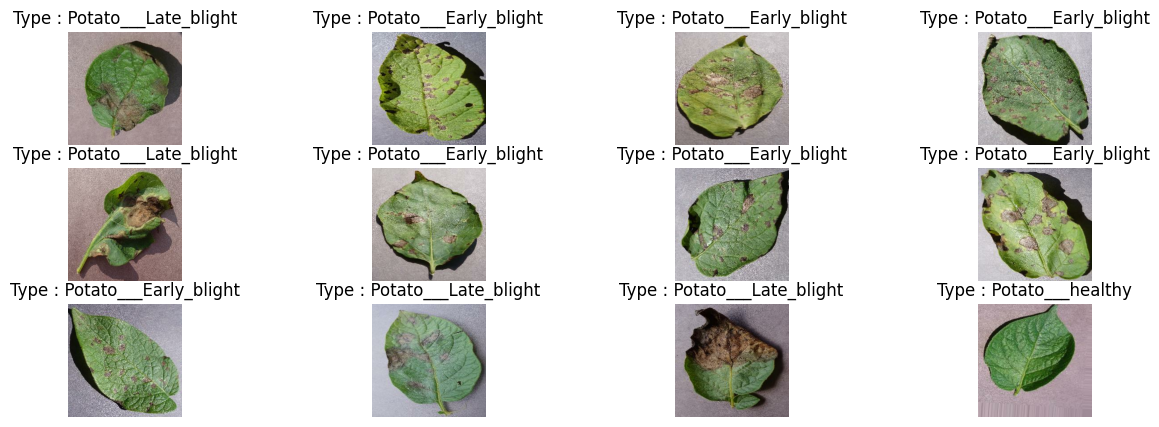

In [31]:
plt.figure( figsize= (15 , 5 ))

for image_batch,label_batch in train_dataset.take(1):
    # print(image_batch.shape , label_batch.numpy())
    
    for index in range(12):
        ax = plt.subplot( 3 , 4 , index + 1)
        
        img = image_batch[index].numpy().astype('uint8')
        plt.title('Type : ' +  class_names[label_batch.numpy()[index]] )    
        plt.imshow(img)
        plt.axis('off')
    

In [32]:
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
vald_ds = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing ,Rescaling,RandomFlip,RandomRotation


In [35]:
preprocess_pipeline = Sequential([
    Resizing(IMAGE_SIZE , IMAGE_SIZE),
    Rescaling(1.0/255),
])

In [36]:
# data augmentation 
data_augmentation = Sequential([
      RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
])

In [37]:
model=  Sequential([
   preprocess_pipeline,
   data_augmentation,
   
   Conv2D(filters = 4 , kernel_size = (3,3) , padding = 'same' , input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS) , activation = 'relu'),
   MaxPooling2D( (2 , 2)),
   
   Conv2D(filters = 16 , kernel_size = (3,3) , activation = 'relu'),
   MaxPooling2D( (2 , 2)),
   
   Flatten(),
   Dense( 32 , activation = 'relu'),
   
   Dense( len(class_names) , activation = 'softmax' )

])


model.build( input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)  )
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 4)         112       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 63, 63, 16)          0         
 g2D)                                                 

In [38]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer = 'adam',
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [39]:
model_history = model.fit(
    train_ds,
    epochs = 10 , 
    verbose = 1 , 
    validation_data = vald_ds
    )

Epoch 1/10


c:\Users\vk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


29/29 [==============================] - 54s 2s/step - loss: 1.4714 - accuracy: 0.4789 - val_loss: 0.8473 - val_accuracy: 0.6033
Epoch 2/10
29/29 [==============================] - 49s 2s/step - loss: 0.7892 - accuracy: 0.6244 - val_loss: 0.6936 - val_accuracy: 0.6600
Epoch 3/10
29/29 [==============================] - 45s 2s/step - loss: 0.6255 - accuracy: 0.6611 - val_loss: 0.6193 - val_accuracy: 0.6667
Epoch 4/10
29/29 [==============================] - 46s 2s/step - loss: 0.5195 - accuracy: 0.6678 - val_loss: 0.5338 - val_accuracy: 0.7367
Epoch 5/10
29/29 [==============================] - 50s 2s/step - loss: 0.4393 - accuracy: 0.8378 - val_loss: 0.5740 - val_accuracy: 0.7867
Epoch 6/10
29/29 [==============================] - 52s 2s/step - loss: 0.3659 - accuracy: 0.8878 - val_loss: 0.4060 - val_accuracy: 0.8367
Epoch 7/10
29/29 [==============================] - 55s 2s/step - loss: 0.2549 - accuracy: 0.9344 - val_loss: 0.3577 - val_accuracy: 0.8700
Epoch 8/10
29/29 [=============

In [40]:
score = model.evaluate(test_ds)
print('Accuracy : ' , score[1])
print('Loss : ' , score[0])

10/10 [==============================] - 4s 341ms/step - loss: 0.1326 - accuracy: 0.9567
Accuracy :  0.9566666483879089
Loss :  0.13261814415454865


In [41]:
y_pred = model.predict(test_ds.take(1))
y_pred = [ np.argmax(y) for y in y_pred]
y_pred[:5]

1/1 [==============================] - 1s 732ms/step


[1, 0, 1, 0, 1]

In [43]:
y_test = []
for _ , label in test_ds.take(1):
    y_test = label.numpy()
    
y_test[:5]

array([1, 1, 0, 2, 1])

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        12
           1       0.36      0.50      0.42        10
           2       0.33      0.20      0.25        10

    accuracy                           0.34        32
   macro avg       0.34      0.34      0.33        32
weighted avg       0.34      0.34      0.33        32



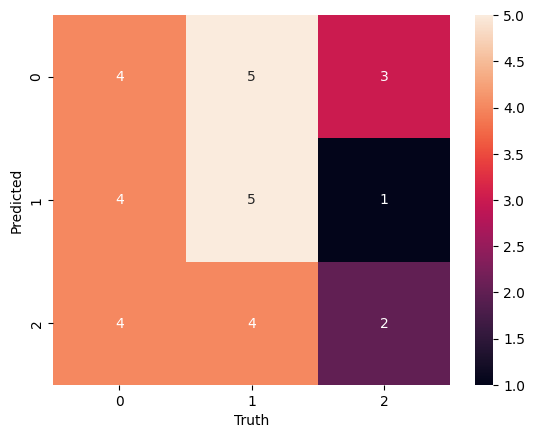

In [48]:
from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns

print(classification_report(y_test , y_pred) )
sns.heatmap(confusion_matrix(y_test , y_pred) , annot=True)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

# Plotting the Accuracy and Loss Curves

In [45]:
history = model_history.history

In [46]:
acc= history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss= history['val_loss']

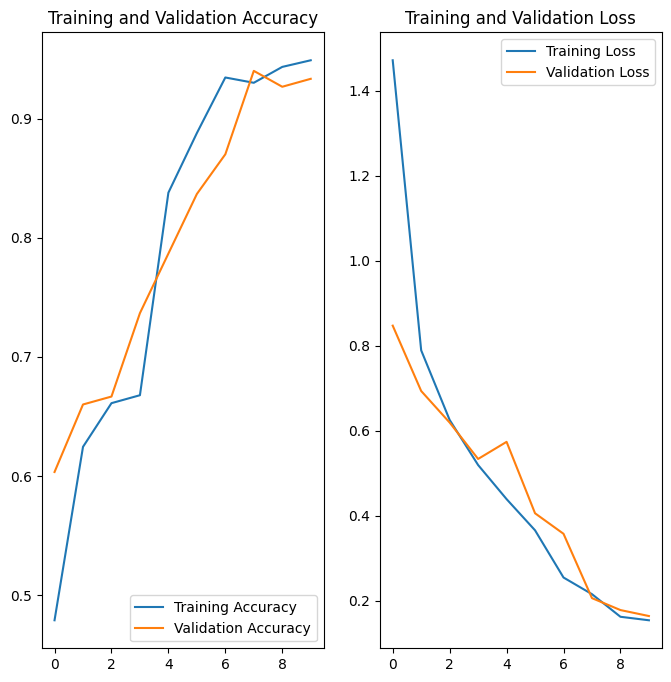

In [51]:
plt.figure(figsize=(8, 8))

EPOCHS = 10
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

1/1 [==============================] - 1s 587ms/step


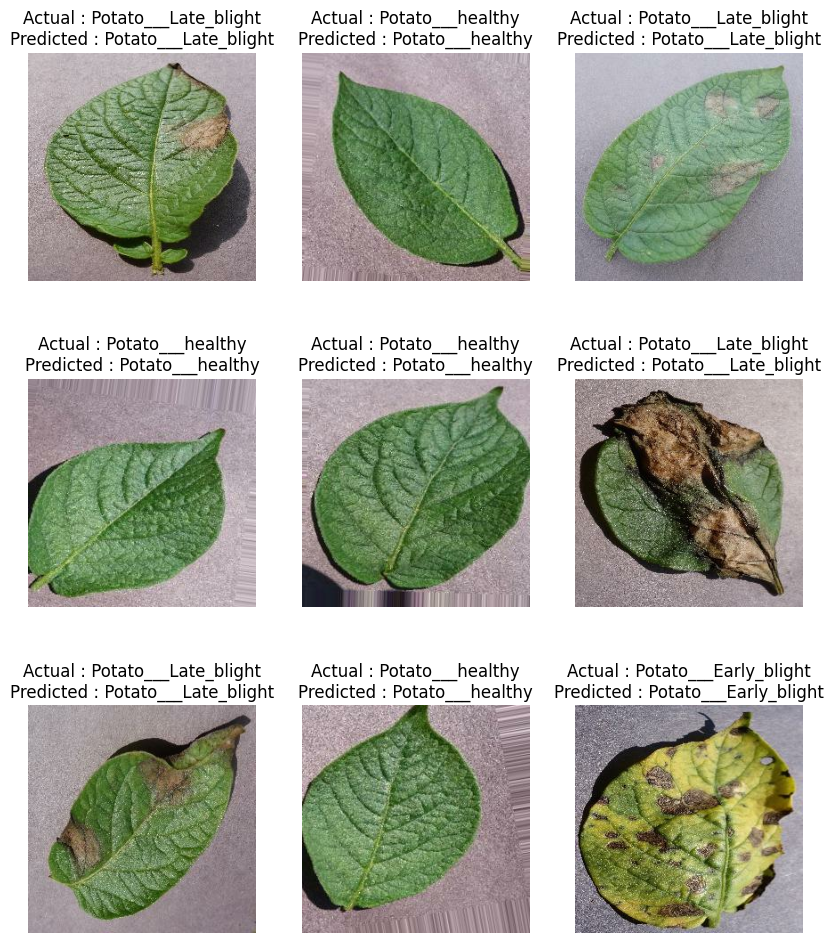

In [52]:
plt.figure( figsize= (10 , 12 ))

for image_batch,label_batch in test_ds.take(1):
    
    img_preds = model.predict(   image_batch  )
    
    for index in range(9):
        
        ax = plt.subplot( 3 , 3 , index + 1)
        
        img = image_batch[index].numpy().astype('uint8')
        target = class_names[label_batch[index].numpy()]
        
        predicted_index =  np.argmax( img_preds[index] )
        img_pred = class_names[predicted_index]
        
        plt.title('Actual : ' + target  + '\nPredicted : ' + img_pred   )    
        plt.imshow(img)
        
        plt.axis('off')
    

# Save Model
* We append the model to the list of models as a new version


In [53]:
model.save('../tf_model/1')

INFO:tensorflow:Assets written to: ../tf_model/1\assets


INFO:tensorflow:Assets written to: ../tf_model/1\assets


In [54]:
# Save model in h5 format so that there is just one file and we can upload that to GCP conveniently
model.save("../potatoes.h5")

c:\Users\vk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
